# Tutorial 2: Entanglement Forging with Quantum Serverless

**Entanglement forging** is a method which allows us to represent expectation values of a 2n-qubit wavefunction as sums of multiple expectation values of n-qubit states, embedded in a classical optimization, thus doubling the size of the system that can be exactly simulated with a fixed number of qubits.

Furthermore, entanglement forging permits the circuits necessary for the n-qubit simulations to be shallower, relaxing requirements on gate error and connectivity, at the cost of increased quantum and classical runtimes.

Entanglement forging is comprised of the following steps. See the [explanatory material](https://github.com/Qiskit-Extensions/circuit-knitting-toolbox/blob/main/docs/explanation/entanglement_forging/index.rst) for more detailed information:

***Estimate the ground state energy of a given system, Ĥ<sub>2n</sub>, with respect to a 2n-qubit wavefunction,Ψ<sub>2n</sub>, using only n qubits***
 1. **Decompose**:
  * Specify the parameterized, n-qubit ansatz circuit, **Ψ<sup>θ</sup><sub>n</sub>**, and select the Schmidt terms over which to optimize.
      * The same circuit will be used for both n-qubit subsystems, U and V
      * Different Schmidt terms may be selected for each subsystem, but the number of expectation values calculated at each loop would increase
  * Decompose **Ψ<sub>2n</sub>** into k, n-qubit ansatze, [Ψ<sub>n<sub>0</sub></sub>, ..., Ψ<sub>n<sub>k</sub></sub>], based on the input ansatz circuit and the selected Schmidt terms
  * Decompose **Ĥ<sub>2n</sub>** into j, n-qubit observables, [H<sub>n<sub>0</sub></sub>, ..., H<sub>n<sub>j</sub></sub>]


 2. **Evaluate**:
  * Apply ansatz circuit parameters, **θ<sub>i</sub>**
  * Calculate expectation values for each basis of the decomposed observable with respect to the selected Schmidt basis and the new ansatz parameters: **[<Ψ<sup>θ<sub>0</sub></sup><sub>0</sub>|H<sub>0</sub>|Ψ<sup>θ<sub>0</sub></sup><sub>0</sub>>, ..., <Ψ<sup>θ<sub>i</sub></sup><sub>k</sub>|H<sub>j</sub>|Ψ<sup>θ<sub>i</sub></sup><sub>k</sub>>]**
  
  
 3. **Reconstruct** 
  * Use the expectation values to reconstruct an estimation of the expectation value for the 2n-qubit system, **<Ψ<sub>2n</sub>|H<sub>2n</sub>|Ψ<sub>2n</sub>>**
  
  
 4. **If energy value has not converged to a minima, update θ<sub>i</sub> to θ<sub>i+1</sub> and continue with Step 2.**
  
  
------
  
  
[**Quantum Serverless**](https://github.com/Qiskit-Extensions/quantum-serverless) is a platform built to enable distributed computing across a variety of classical and quantum backends.

In this demo, we will show how to use quantum serverless to send the entanglement forging workflow to a remote cluster.

### Instantiate the `ElectronicStructureProblem`

Next, we set up the $\mathrm{H}_2$ molecule, specify the driver and converter, and instantiate an  `ElectronicStructureProblem`, just like is done in the [Qiskit Nature VQE tutorial](https://github.com/Qiskit/qiskit-nature/blob/stable/0.4/docs/tutorials/03_ground_state_solvers.ipynb).

In [1]:
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import PySCFDriver
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.mappers.second_quantization import JordanWignerMapper
from qiskit_nature.converters.second_quantization import QubitConverter

molecule = Molecule(
    geometry=[
        ("H", [0.0, 0.0, 0.0]),
        ("H", [0.0, 0.0, 0.735]),
    ],
    charge=0,
    multiplicity=1,
)
driver = PySCFDriver.from_molecule(molecule=molecule, basis="sto3g")
problem = ElectronicStructureProblem(driver)
converter = QubitConverter(JordanWignerMapper())

### Prepare the bitstrings and the ansatz

The ansatz for Entanglement Forging consists of a set of input bitstrings and a parameterized circuit.  (See the "explanatory material" section of the documentation for additional background on the method.) For this demo, we will use the same bitstrings and ansatz for both the U and V subsystems, and we will use the `TwoLocal` circuit from Qiskit.

In [2]:
from circuit_knitting_toolbox.entanglement_forging import EntanglementForgingAnsatz
from qiskit.circuit.library import TwoLocal

ansatz = EntanglementForgingAnsatz(
    circuit_u=TwoLocal(2, [], "cry", [[0, 1], [1, 0]], reps=1),
    bitstrings_u=[(1, 0), (0, 1)],
)

ansatz.circuit_u.draw()

┌──────────────────────┐
q_0: ┤0                     ├
     │  TwoLocal(θ[0],θ[1]) │
q_1: ┤1                     ├
     └──────────────────────┘

### Set up the Qiskit Runtime Service

The Qiskit Runtime Service provides access to Qiskit Runtime Primitives and quantum backends. See the [Qiskit Runtime documentation](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/) for more information.  Here, we specify the backend(s) to be used to evaluate the circuits. Backends could be [simulator(s) and/or quantum device(s)](https://quantum-computing.ibm.com/services/resources?tab=systems).

Alternatively, if a Qiskit Runtime Service is not passed, then a local simulator will be used with the [Qiskit Primitives](https://qiskit.org/documentation/apidoc/primitives.html), and the `backend_names` argument will be ignored.

In [4]:
from qiskit_ibm_runtime import QiskitRuntimeService

# By default, use a local simulator to implement the Qiskit Runtime Primitives
#service = None

# Uncomment the following line to instead use the Qiskit Runtime Service.
service = QiskitRuntimeService(channel="ibm_quantum")

backend_names = ["ibmq_qasm_simulator"] * 2

### Set up Quantum Serverless

We can use Quantum Serverless to send the entanglement forging routine to a remote compute resource. For this tutorial, we will use our local CPU cores as the compute cluster. See the [Quantum Serverless](https://github.com/Qiskit-Extensions/quantum-serverless) documentation (and below) for more informatin about how to use other clusters.

In [5]:
from quantum_serverless import QuantumServerless

serverless = QuantumServerless()
serverless.providers()

[<Provider: local>]

### Create a wrapper function to send to the remote cluster

Use `Quantum Serverless` to send the solve_remote method to a remote cluster.

Here we create a wrapper function for `EntanglementForgingGroundStateSolver` and its solve method, and we annotate it with the `@run_qiskit_remote()` decorator from Quantum Serverless. This allows us to call this function from a serverless context and have it sent for remote execution on the specified cluster.

In [6]:
from typing import Optional, Sequence, Tuple, Dict
from qiskit.algorithms.optimizers import Optimizer
from qiskit.result import Result
from quantum_serverless import run_qiskit_remote
from circuit_knitting_toolbox.entanglement_forging import EntanglementForgingGroundStateSolver

@run_qiskit_remote()
def solve_remote(
    problem: ElectronicStructureProblem,
    ansatz_circuit: EntanglementForgingAnsatz,
    optimizer: Optimizer,
    service_args: Optional[Dict] = None,
    backend_names: Optional[Sequence[str]] = None,
    initial_point: Optional[Sequence[float]] = None,
    orbitals_to_reduce: Optional[Sequence[int]] = None,
) -> Result:
    """
    Wrapper function for running entanglement forging VQE on a remote resource.

        Args:
            - problem: A class encoding the problem to be solved
            - ansatz: The ansatz
            - optimizer: Optimizer to use to optimize the ansatz circuit parameters
            - service_args: The arguments for instantiating a QiskitRuntimeService
            - backend_names: List of backend names to use during parallel computation
            - initial_point: Initial values for ansatz parameters
            - orbitals_to_reduce: List of orbital indices to remove from the problem before
                decomposition.
        Returns:
            - An interpreted EigenstateResult
    """
    service = QiskitRuntimeService(**service_args) if service_args else None

    solver = EntanglementForgingGroundStateSolver(
        ansatz=ansatz,
        service=service,
        optimizer=optimizer,
        backend_names=backend_names,
        initial_point=initial_point,
        orbitals_to_reduce=orbitals_to_reduce,
    )
    result = solver.solve(problem)

    return result

### Run entanglement forging on a remote cluster

Once a user has set up their `ElectronicStructureProblem`, `EntanglementForgingAnsatz`, and other program options, the only thing remaining is call `EntanglementForgingGroundStateSolver.solve`, which we have wrapped in the `solve_remote` function.

We will call the `solve_remote` function within a QuantumServerless context, which means it will be run on the specified cluster. Remember, the default cluster for this demo will use the cores on our local CPU. To specify a new cluster, the `QuantumServerless.set_provider` method should be used.

When the remote function is called, it will return a "future" object, and Python will continue interpreting the next line of code. The get function from quantum-serverless is a blocking command which should be used to retrieve the results of the remote function via the "future" object. The program will not continue past the get call until the results of the remote function are returned.

In [8]:
%%capture

import numpy as np
from qiskit.algorithms.optimizers import COBYLA
from quantum_serverless import get

optimizer = COBYLA()
service_args = None if service is None else service.active_account()
initial_point = [0.0, np.pi / 2]

with serverless:
    forging_result_future = solve_remote(
        problem,
        ansatz,
        optimizer,
        service_args=service_args,
        backend_names=backend_names,
        initial_point=initial_point,
    )
    results = get(forging_result_future)

### Visualize the results

Visualize the convergence of the estimated ground state energy and the Schmidt coefficients as the ansatz parameters are optimized.

Energy:


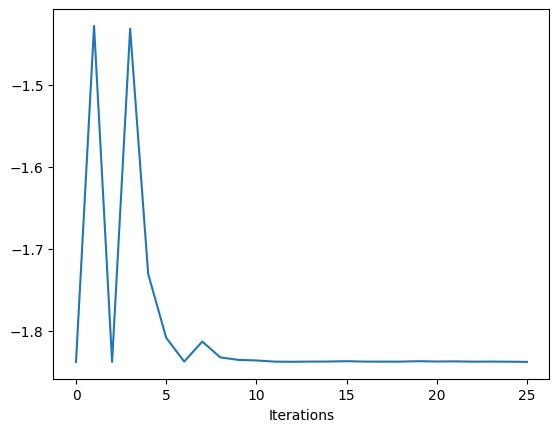

Schmidt Coefficients:


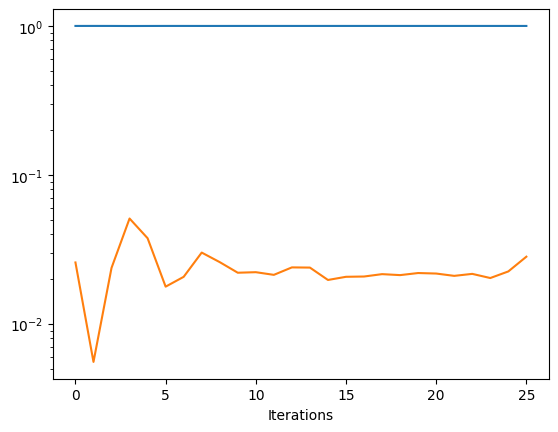

Parameters:


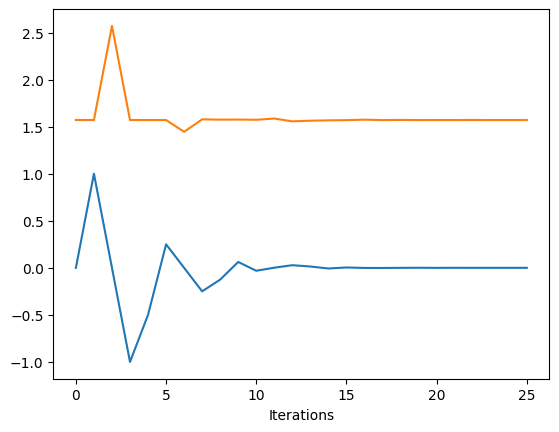

In [9]:
import matplotlib.pyplot as plt

print("Energy:")
plt.plot([evaluation.eigenvalue for evaluation in results.history])
plt.xlabel("Iterations")
plt.show()

print("Schmidt Coefficients:")
plt.plot([abs(evaluation.eigenstate) for evaluation in results.history])
plt.xlabel("Iterations")
plt.yscale("log")
plt.show()

print("Parameters:")
plt.plot([evaluation.parameters for evaluation in results.history])
plt.xlabel("Iterations")
plt.show()

In [10]:
import qiskit.tools.jupyter

%qiskit_version_table

### This code is a Qiskit project.

© Copyright IBM 2022.

This code is licensed under the Apache License, Version 2.0. You may
obtain a copy of this license in the LICENSE.txt file in the root directory
of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.

Any modifications or derivative works of this code must retain this
copyright notice, and modified files need to carry a notice indicating
that they have been altered from the originals.